<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W2_DNN_train_tune_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

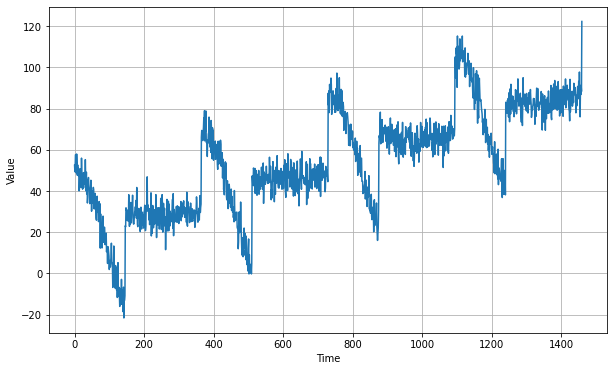

In [2]:
# Set the data series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Create dataset from series and pass the series to it
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Mapping a dataset element to a (window_size + 1) batch size dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Shuffle the dataset at the shuffle_buffer and split into features and labels
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Batch the select batch size
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [0]:
# Split dataset into training and validation sets
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# Buid the DNN model

# Set the constants that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create DNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
)

model.fit(
    dataset,
    epochs=100,
    verbose=1
)

print("Training complete")

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 838.4261
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 96.2877
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 68.0851
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 66.6612
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 64.7080
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 63.2394
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 62.1786
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 61.2640
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 59.8772
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 58.8659
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 57.8856
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 57.8980
Epoch 13/100
31/31 [====

In [0]:
# Forecast every time points of time series
forecast = []

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

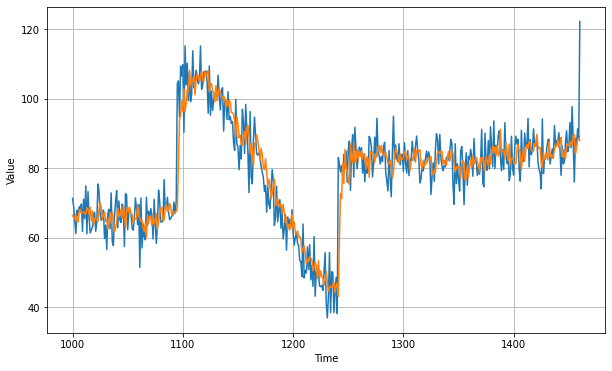

In [7]:
# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Actual -- Blue, Prediction -- Orange

In [8]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# mae = np.abs(errors).mean()

4.91048

In [9]:
# Buid the DNN model with optimal learning rate

# Set the constants that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create DNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Call the callback and chage the learning rate to value based on the epoch number
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
    # epoch 1: 1e-8 * 10 to the power of 1/20
    # epoch 100: 1e-8 * 10 to the power of 100/20


optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    dataset,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

print("Training complete")

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 83.9649 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 83.2617 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 82.8890 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 82.7175 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 82.6084 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 82.5305 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 82.4703 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 82.3678 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 82.2580 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 82.1578 - lr: 2.8184e-08
Epoch 11/100
31/31 

(1e-08, 0.001, 0.0, 300.0)

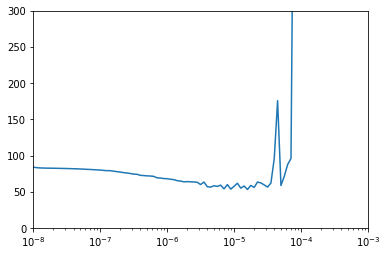

In [10]:
# Plot the loss/epoch
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

# y axis -- loss
# x axis -- learning rate
# Stable point -- 7e-6

In [11]:
# Retrain the DNN model with stable learning rate point

# Set the constants that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create DNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

# Chage the learning rate so change the epochs numbers bit longer
history = model.fit(
    dataset,
    epochs=500,
    verbose=2
)

print("Training complete")

Epoch 1/500
31/31 - 0s - loss: 336.2278
Epoch 2/500
31/31 - 0s - loss: 99.1157
Epoch 3/500
31/31 - 0s - loss: 74.7380
Epoch 4/500
31/31 - 0s - loss: 66.9947
Epoch 5/500
31/31 - 0s - loss: 65.2311
Epoch 6/500
31/31 - 0s - loss: 59.7620
Epoch 7/500
31/31 - 0s - loss: 57.3610
Epoch 8/500
31/31 - 0s - loss: 55.7744
Epoch 9/500
31/31 - 0s - loss: 53.2512
Epoch 10/500
31/31 - 0s - loss: 53.8831
Epoch 11/500
31/31 - 0s - loss: 51.7259
Epoch 12/500
31/31 - 0s - loss: 52.3276
Epoch 13/500
31/31 - 0s - loss: 50.1093
Epoch 14/500
31/31 - 0s - loss: 53.1888
Epoch 15/500
31/31 - 0s - loss: 49.4016
Epoch 16/500
31/31 - 0s - loss: 47.5408
Epoch 17/500
31/31 - 0s - loss: 47.4756
Epoch 18/500
31/31 - 0s - loss: 49.4047
Epoch 19/500
31/31 - 0s - loss: 47.0856
Epoch 20/500
31/31 - 0s - loss: 46.7009
Epoch 21/500
31/31 - 0s - loss: 45.6998
Epoch 22/500
31/31 - 0s - loss: 46.4979
Epoch 23/500
31/31 - 0s - loss: 44.8506
Epoch 24/500
31/31 - 0s - loss: 44.9540
Epoch 25/500
31/31 - 0s - loss: 46.5919
Epoch 26

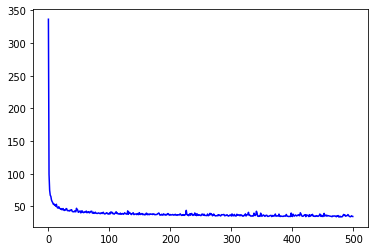

In [12]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[51.72593688964844, 52.327632904052734, 50.10932540893555, 53.18877029418945, 49.40156555175781, 47.54081344604492, 47.47560501098633, 49.404747009277344, 47.0855827331543, 46.70088195800781, 45.699806213378906, 46.49789810180664, 44.850608825683594, 44.954044342041016, 46.59191131591797, 44.46086120605469, 43.67106628417969, 44.545066833496094, 44.27559280395508, 46.55746078491211, 46.355918884277344, 43.47846603393555, 43.28903579711914, 43.25334930419922, 43.772850036621094, 42.873558044433594, 44.03733444213867, 44.55043411254883, 44.85314178466797, 42.180015563964844, 41.83100509643555, 41.68235778808594, 41.637969970703125, 43.05009078979492, 41.83578872680664, 41.73208999633789, 47.03966522216797, 45.1226692199707, 44.34664535522461, 40.82292175292969, 41.489253997802734, 42.41558837890625, 42.9372444152832, 40.044307708740234, 40.773555755615234, 43.29513931274414, 41.295963287353516, 40.644718170166016, 40.367149353027344, 41.62898635864258, 41.12053680419922, 41.2808036804199

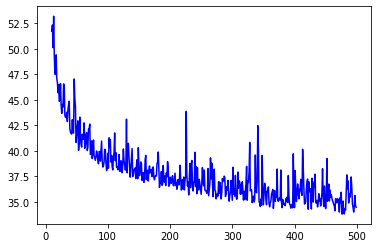

In [13]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [0]:
# Forecast every time points of time series
forecast = []

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

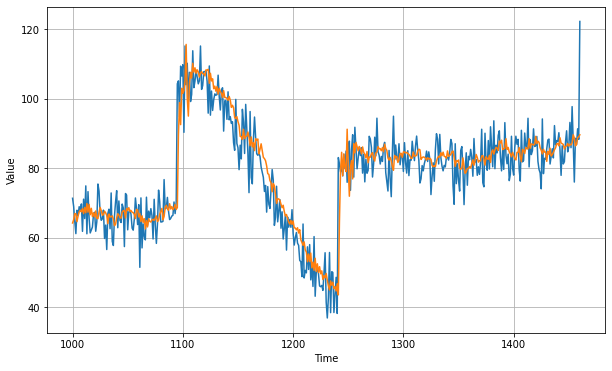

In [15]:
# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Actual -- Blue, Prediction -- Orange

In [16]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# mae = np.abs(errors).mean()
# Sgnificantly lower than earlier

4.8419414